# Simple VGG16

Check the devices available. Note you need to have the right version (as in CPU vs GPU version) of TensorFlow installed to harnes the GPU. 

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16469044431399882192
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3423059968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1094298270593421300
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


This can take a bit of time if it's the first time you're running it. It will download a Keras model equivalent to VGG-16.

## Build Model

In [2]:
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.models import Sequential, Model

def ConvBlock(layers, model, num_filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers):
        model.add(ZeroPadding2D((1,1))) # zero padding of size 1
        model.add(Conv2D(num_filters, (3, 3), activation='relu')) # 3x3 filter size 
        
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_first'))

def FCBlock(model, size=4096):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(size, activation='relu'))
    model.add(Dropout(0.5))
    
def my_VGG16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(3,106,106)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)

    model.add(Dense(37, activation = 'sigmoid'))
    return model

Using TensorFlow backend.


In [3]:
from keras.optimizers import RMSprop


# Then create the corresponding model 
my_model = my_VGG16()
optimizer = RMSprop(lr=1e-6)
my_model.compile(loss='mean_squared_error', optimizer=optimizer)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 106, 106)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 5, 108, 106)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 106, 64)        61120     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 5, 108, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 106, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 53, 32)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 5, 55, 32)         0         
__________

# Paths and Data Splitting
Remember to check for the path of the directory

In [4]:
import glob
import pandas as pd

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the original training dataset
    '''
    return glob.glob(target + '/*.jpg')

data_dir = r'../data'
original_data_dir = data_dir + '/images_training_rev1'
test_data_dir     = data_dir + '/images_test_rev1'

all_files = pd.DataFrame(load_img_paths(original_data_dir))
test_files = load_img_paths(test_data_dir)

train_paths = all_files.sample(frac=0.95)[0].values.tolist()
valid_paths = all_files.sample(frac=0.05)[0].values.tolist()
train_paths[0:5]

['../data/images_training_rev1\\865298.jpg',
 '../data/images_training_rev1\\776344.jpg',
 '../data/images_training_rev1\\783588.jpg',
 '../data/images_training_rev1\\357414.jpg',
 '../data/images_training_rev1\\913806.jpg']

In [5]:
df = pd.read_csv(data_dir + '/training_solutions_rev1.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## Training

In [6]:
from skimage.transform import resize
from skimage.io import imread

def preprocess_image(fname):
    sample_img = imread(train_paths[0])
    sample_img = sample_img.T[:,106:106*3,106:106*3]
    sample_img = resize(sample_img, (106, 106, 3), mode='reflect').T
    return sample_img

In [7]:
from os import path
from random import shuffle

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Will output sequence of tuples (image, test) given a datapath
def fetch_images(paths):
    while 1: # while 1 makes it loop around when we run out of images
        for fname in paths:
            image = preprocess_image(fname)
            image = img_to_array(image)
            train = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            file_id = path.split(fname)[-1] \
                          .split('.')[0]
            fd = int(file_id)
            test = df.loc[df['GalaxyID'] == fd].loc[:,df.columns != 'GalaxyID']
            yield (train, test)
        
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)

# history function
history = LossHistory()

tmp directory already exists


In [8]:
batch_size = 32
steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

print('Traning images:   %d' % len(train_paths))
print('Validtn images:   %d' % len(valid_paths))
print('Training batch:   %d' % steps_per_epoch)
print('Validation batch: %d' % validation_steps)

Traning images:   58499
Validtn images:   3079
Training batch:   1828
Validation batch: 96


In [9]:
hist = my_model.fit_generator(fetch_images(train_paths),
    steps_per_epoch=steps_per_epoch, 
    epochs=50,
    validation_data=fetch_images(valid_paths),
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[history,checkpointer,early_stopping]
)

Epoch 1/50
 - 110s - loss: 0.0787 - val_loss: 0.0270

Epoch 00001: val_loss improved from inf to 0.02700, saving model to tmp/weights.hdf5
Epoch 2/50
 - 107s - loss: 0.0316 - val_loss: 0.0260

Epoch 00002: val_loss improved from 0.02700 to 0.02602, saving model to tmp/weights.hdf5
Epoch 3/50
 - 106s - loss: 0.0298 - val_loss: 0.0251

Epoch 00003: val_loss improved from 0.02602 to 0.02510, saving model to tmp/weights.hdf5
Epoch 4/50
 - 106s - loss: 0.0299 - val_loss: 0.0237

Epoch 00004: val_loss improved from 0.02510 to 0.02374, saving model to tmp/weights.hdf5
Epoch 5/50
 - 107s - loss: 0.0288 - val_loss: 0.0296

Epoch 00005: val_loss did not improve from 0.02374
Epoch 6/50
 - 106s - loss: 0.0287 - val_loss: 0.0277

Epoch 00006: val_loss did not improve from 0.02374
Epoch 7/50
 - 107s - loss: 0.0290 - val_loss: 0.0276

Epoch 00007: val_loss did not improve from 0.02374
Epoch 8/50
 - 107s - loss: 0.0300 - val_loss: 0.0288

Epoch 00008: val_loss did not improve from 0.02374
Epoch 9/50
 

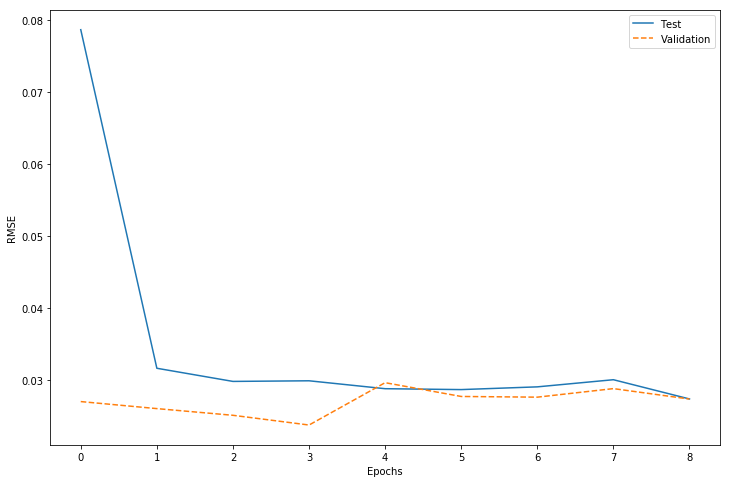

In [10]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Testing and Benchmarking

We load the best weights we've found, and load them in a model.

In [11]:
# Load best model weights
from keras.models import load_model
model = load_model('tmp/weights.hdf5')

Then, run all 79975 test images through the model, this takes about 10-15 minutes.

In [12]:
def fetch_test_images():
    while 1:
        for fname in test_files:
            image = preprocess_image(fname)
            image = img_to_array(image)
            test = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            yield (test)
            
predictions = model.predict_generator(fetch_test_images(),
                       val_samples = len(test_files),
                        max_q_size = 32,)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<generator..., steps=79975, max_queue_size=32)`
  # This is added back by InteractiveShellApp.init_path()


In [13]:
predictions.shape

(79975, 37)

Record all results into a csv file with the id and the predictions. The CSV file will be about 40MB big. We only load the `all_zeros.csv` file for its header.

In [14]:
header = open('../data/all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_1.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(test_files)):
        fname = test_files[i]
        file_id = path.split(fname)[-1] \
                      .split('.')[0]
        pred = predictions[i]
        outline = file_id + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")